In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.spatial.distance import pdist
import pandas as pd
from read_roi import read_roi_file
from math import ceil, sqrt
from cluster.pair_correlation import pc_corr, fit_correlation, fit_exponential_gaussian, ripleyLfunction, ripley_ci, fit_exponential
from cluster.ripley import RipleysKEstimator

In [2]:
locs_path = 'test_data\\run15 wtTNF.csv'
roi_path = 'test_data\\0295-0421.roi'

ij_pix_size = 32.0 # nm
pix_x = pix_y = 10.0 # nm
extent_x = 24000.0 # nm
extent_y = 21600.0 # nm
size_x = int(extent_x / pix_x)
size_y = int(extent_y / pix_y)
print(size_x)
print(size_y)
locs_df = pd.read_csv(locs_path)
rois = read_roi_file(roi_path)

for roi_id, roi in rois.items():
    for k, v in roi.items():
        if not isinstance(v, str):
            roi[k] = (float(v) * ij_pix_size) / pix_x # pixels

# prepare roi for pair-correlation, rows and columns --> y,x
roi_array = [int(roi['top']), int(roi['top'] + roi['height']), int(roi['left']), int(roi['left'] + roi['width'])]

2400
2160


In [3]:
bins_x = size_x
bins_y = size_y
img = np.histogramdd(locs_df.as_matrix(['y [nm]', 'x [nm]']), bins=(bins_y, bins_x))[0]

<IPython.core.display.Javascript object>


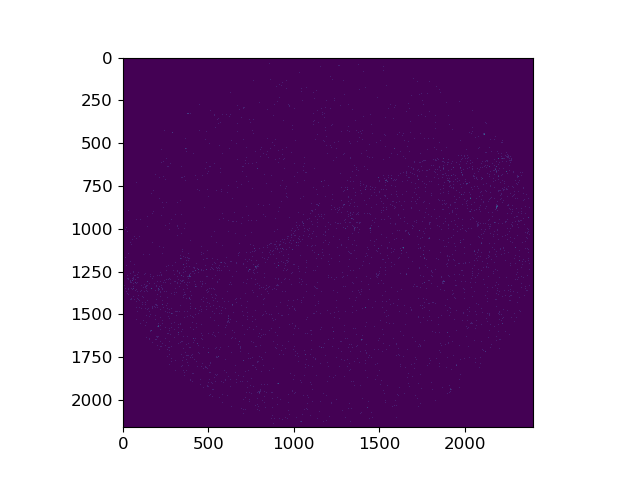

In [4]:
figure = plt.figure()
ax = figure.add_subplot(111)
ax.imshow(img, interpolation='nearest')
plt.show()

In [5]:
g, r = pc_corr(image1=img, image2=img, region=roi_array, rmax=80)

4002.0
82080.0


<IPython.core.display.Javascript object>


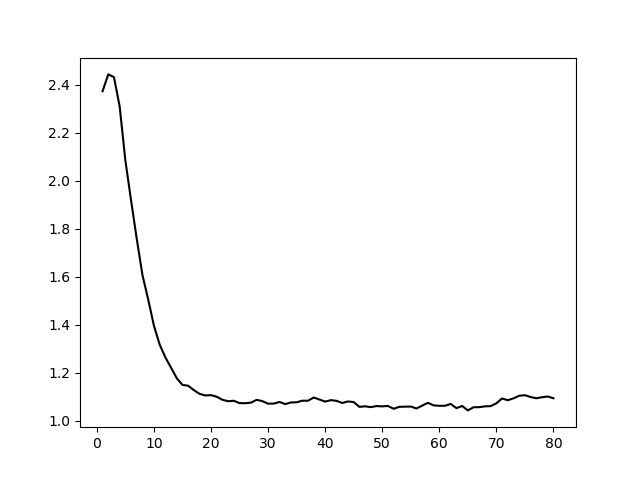

In [6]:
figure2 = plt.figure()
ax2 = figure2.add_subplot(111)
ax2.plot(r[1:], g[0, 1:], 'k-')
plt.show()

In [9]:
# guess = [density of probe, sqrt(2)*PSF [half width], amplitude of exponential part, decay length of exponential]
guess = [1, 10, 20]
curve, result = fit_correlation(g, r * pix_x, fit_exponential, guess=guess)

(80,)
(80,)


In [10]:
result

array([ 1.06069086,  1.90335097, 63.84520127])

<IPython.core.display.Javascript object>


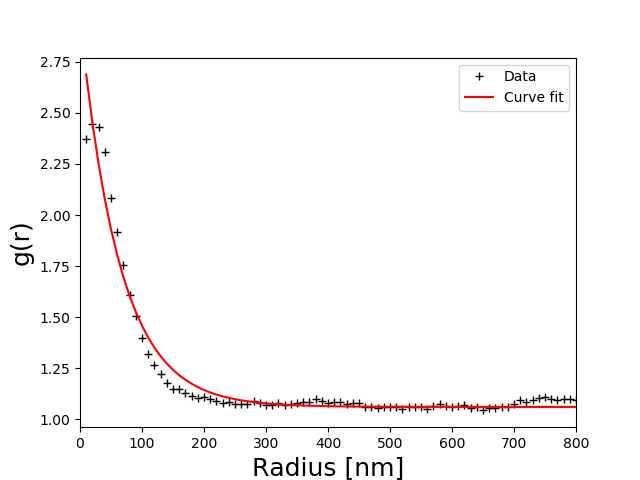

In [11]:
figure3 = plt.figure()
ax3 = figure3.add_subplot(111)
ax3.plot(r[1:]*pix_x, g[0, 1:], 'k+', label='Data')
ax3.plot(r[1:]*pix_x, curve[1:], 'r-', label='Curve fit')
ax3.set_xlim([0, 80*pix_x])
ax.tick_params(labelsize='large')
ax3.legend()
plt.xlabel('Radius [nm]', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.show()

In [2]:
locs_path = 'test_data\\run15 wtTNF.csv'
roi_path = 'test_data\\0295-0421.roi'

ij_pix_size = 32.0 # nm
locs_df = pd.read_csv(locs_path)
rois = read_roi_file(roi_path)

for roi_id, roi in rois.items():
    for k, v in roi.items():
        if not isinstance(v, str):
            roi[k] = (float(v) * ij_pix_size) # nm

roi = rois['0295-0421']
roi_locs = locs_df[(locs_df['x [nm]'] > roi['left']) &
                    (locs_df['x [nm]'] < roi['left'] + roi['width']) &
                    (locs_df['y [nm]'] > roi['top']) &
                    (locs_df['y [nm]'] < roi['top'] + roi['height'])].reset_index(drop=True)
area = roi['width'] * roi['height']
rmax = 500 #ceil(sqrt(area / 2))
x_min = roi['left']
x_max = roi['left'] + roi['width']
y_min = roi['top']
y_max = roi['top'] + roi['height']

In [3]:
Kdata = RipleysKEstimator(area, x_max=x_max, x_min=x_min, y_max=y_max, y_min=y_min)
Kest = RipleysKEstimator(area=area, x_max=x_max, y_max=y_max, x_min=x_min, y_min=y_min)

r = np.linspace(0, rmax, 100)
H = Kdata.Hfunction(roi_locs.as_matrix(['x [nm]', 'y [nm]']), r, mode='none')
dist = pdist(roi_locs.as_matrix(['x [nm]', 'y [nm]']))
print(dist.shape)

(8231653,)
(8231653,)


<IPython.core.display.Javascript object>


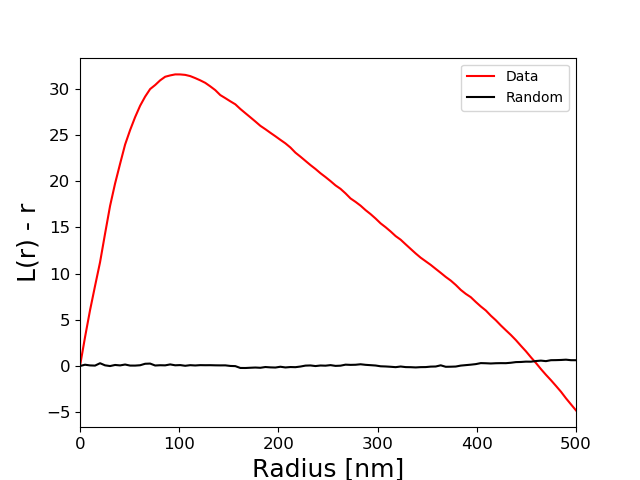

In [8]:
x = np.random.uniform(low=x_min, high=x_max, size=(len(roi_locs.index), 1))
y = np.random.uniform(low=y_min, high=y_max, size=(len(roi_locs.index), 1))
rand_xy = np.hstack((x, y))
r = np.linspace(0, rmax, 100)

figure4 = plt.figure()
ax4 = figure4.add_subplot(111)
ax4.plot(np.linspace(0, rmax, 100), H, 'r-', label='Data')
ax4.plot(np.linspace(0, rmax, 100), Kest.Hfunction(rand_xy, r, mode='ripley'), 'k-', label='Random')
ax4.set_xlim([0, rmax])
ax4.tick_params(labelsize='large')
ax4.legend()
plt.xlabel('Radius [nm]', fontsize=18)
plt.ylabel('L(r) - r', fontsize=18)
plt.show()

In [4]:
box = [roi['left'], roi['left'] + roi['width'], roi['top'], roi['top'] + roi['height']]
print(box)
Hci = ripley_ci(int(len(roi_locs.index)), area, box, 10, rmax, 'ripley')

[12064.0, 14912.0, 8000.0, 10880.0]


<IPython.core.display.Javascript object>


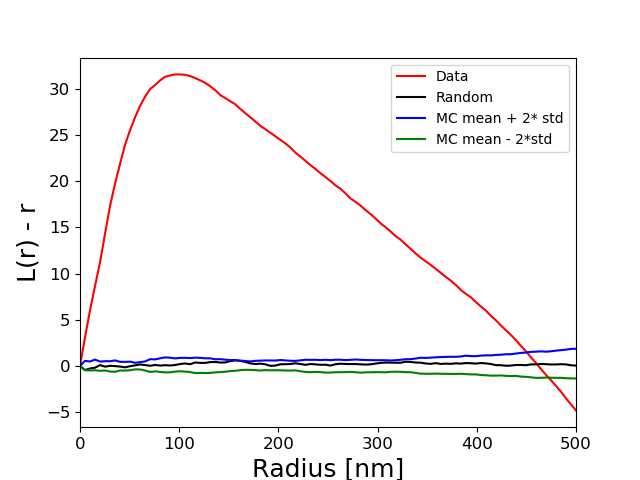

In [10]:
x = np.random.uniform(low=x_min, high=x_max, size=(len(roi_locs.index), 1))
y = np.random.uniform(low=y_min, high=y_max, size=(len(roi_locs.index), 1))
rand_xy = np.hstack((x, y))
Kest = RipleysKEstimator(area=area, x_max=x_max, y_max=y_max, x_min=x_min, y_min=y_min)
r = np.linspace(0, rmax, 100)

figure5 = plt.figure()
ax5 = figure5.add_subplot(111)
ax5.plot(np.linspace(0, rmax, 100), H, 'r-', label='Data')
ax5.plot(np.linspace(0, rmax, 100), Kest.Hfunction(rand_xy, r, mode='ripley'), 'k-', label='Random')
ax5.plot(np.linspace(0, rmax, 100), Hci[0], 'b-', label='MC mean + 2* std')
ax5.plot(np.linspace(0, rmax, 100), Hci[1], 'g-', label='MC mean - 2*std')
ax5.set_xlim([0, rmax])
ax5.tick_params(labelsize='large')
ax5.legend()
plt.xlabel('Radius [nm]', fontsize=18)
plt.ylabel('L(r) - r', fontsize=18)
plt.show()

<IPython.core.display.Javascript object>


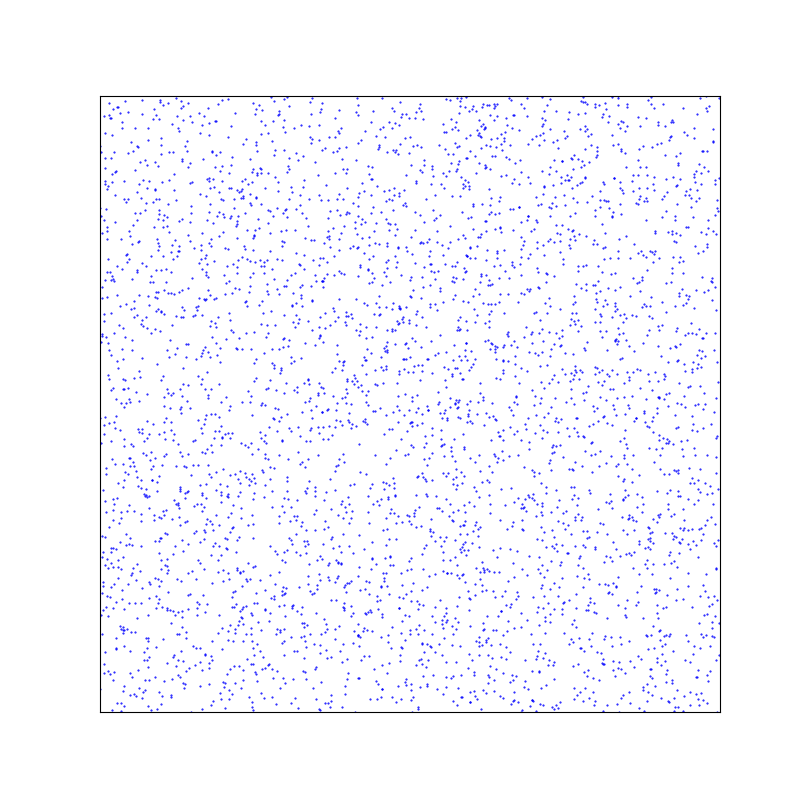

In [11]:
N = len(roi_locs.index)
point_size = 1

figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

def rand_locs(num):
    x = np.random.uniform(low=x_min, high=x_max, size=(num, 1))
    y = np.random.uniform(low=y_min, high=y_max, size=(num, 1))
    rand_xy = np.hstack((x, y))
    return rand_xy

spots = []
for i in range(10):
    points = rand_locs(N)
    p, = ax.plot(points[:, 0], points[:, 1], '.', markersize=point_size, color='b')
    spots.append([p])
    
ani = animation.ArtistAnimation(figure, spots, interval=1000, blit=True)
# ani.save('voronoi.mp4', extra_args=['-vcodec', 'libx264'])
ani.save('rand_points.gif', dpi=80, writer='imagemagick')
plt.show()

<IPython.core.display.Javascript object>


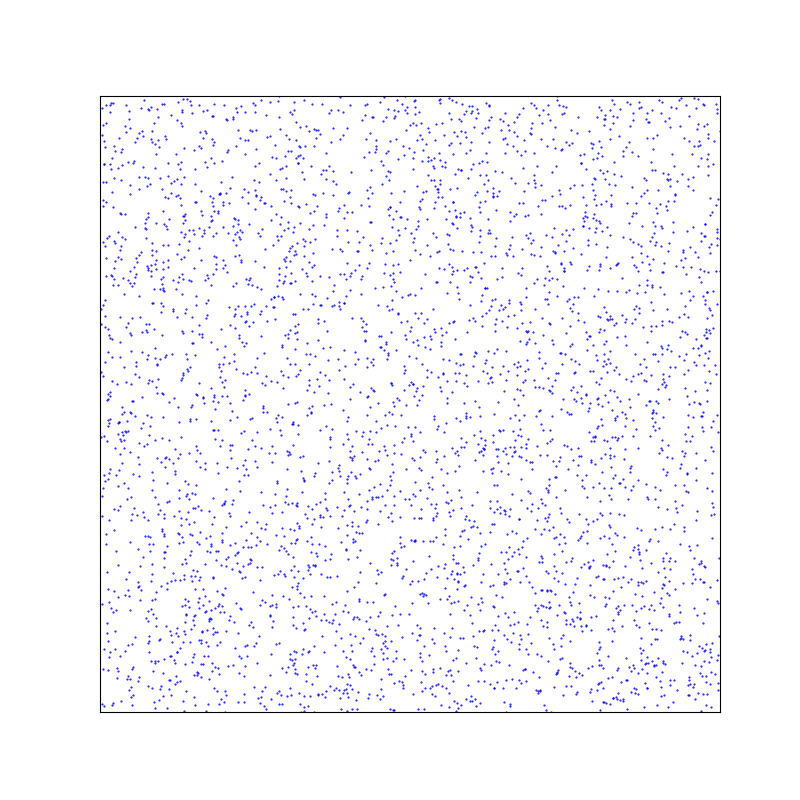

In [7]:
x = np.random.uniform(low=x_min, high=x_max, size=(len(roi_locs.index), 1))
y = np.random.uniform(low=y_min, high=y_max, size=(len(roi_locs.index), 1))
rand_xy = np.hstack((x, y))

figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.plot(x, y, '.', markersize=1, color='b')
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.show()

<IPython.core.display.Javascript object>


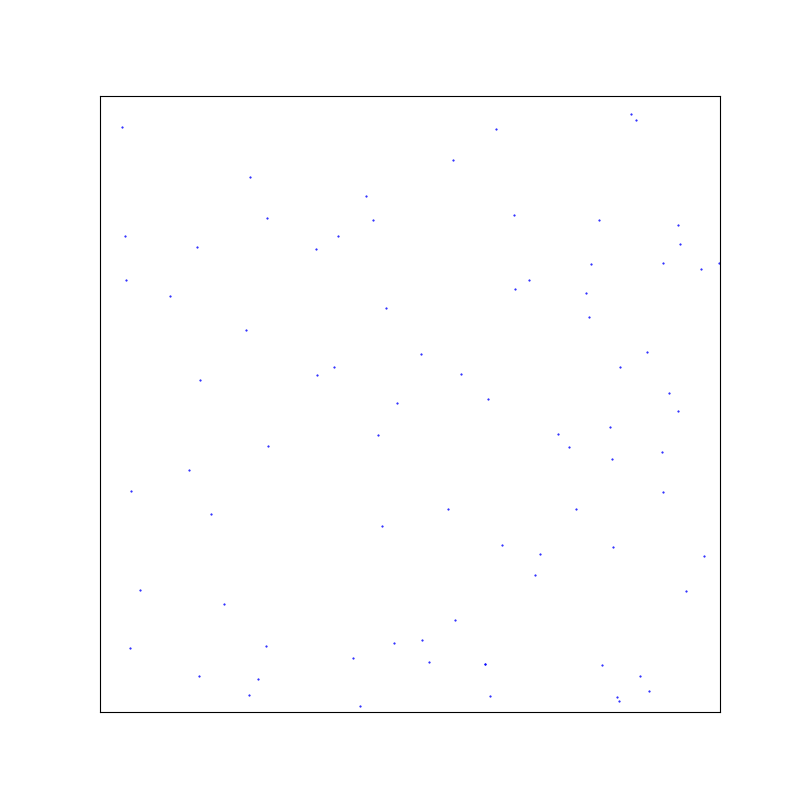

In [13]:
# x = np.linspace(x_min, x_max, int(len(roi_locs.index)/500.0))
# y = np.linspace(y_min, y_max, int(len(roi_locs.index)/500.0))
# xx, yy = np.meshgrid(x, y)
# disp_xy = np.stack((np.ravel(xx), np.ravel(yy)), axis=-1)
# print(disp_xy.shape)

x = np.random.uniform(low=x_min, high=x_max, size=(int(len(roi_locs.index)/50.0), 1))
y = np.random.uniform(low=y_min, high=y_max, size=(int(len(roi_locs.index)/50.0), 1))
disp_xy = np.hstack((x, y))

# x = np.random.poisson(lam=int(x_min + (x_max - x_min) / 2.0), size=(len(roi_locs.index), 1))
# y = np.random.poisson(lam=int(y_min + (y_max - y_min) / 2.0), size=(len(roi_locs.index), 1))
# disp_xy = np.hstack((x, y))
# print(x_min)
# print(int((x_max - x_min) / 2.0))
# print(disp_xy.shape)

figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.plot(disp_xy[:,0], disp_xy[:,1], '.', markersize=1, color='b')
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.show()

<IPython.core.display.Javascript object>


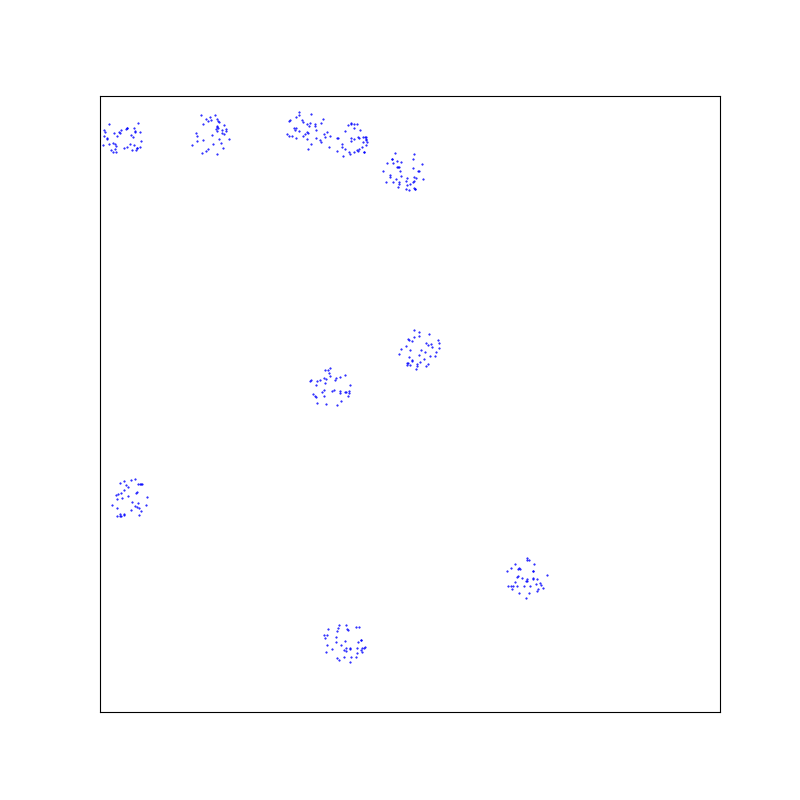

(385, 2)


In [10]:
density = float(area) / float(len(roi_locs.index))

num_clusters = 10

figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
clusters = []
for c in range(num_clusters):
    cluster_seed = np.array(
        (
            np.random.uniform(x_min, x_max, 1),
            np.random.uniform(y_min, y_max, 1)
        )
    )
    
    cluster_radius = 100 #np.random.normal(100, 20)
    
    num_cluster_points = 50 #int(np.random.normal(10, 5))
    cluster = np.array((
                    np.random.uniform(-cluster_radius,cluster_radius,num_cluster_points),
                    np.random.uniform(-cluster_radius,cluster_radius,num_cluster_points)))

    cluster = cluster[:,np.sqrt(np.square(cluster[0,:]) + np.square(cluster[1,:])) < cluster_radius]
    cluster[0,:] = cluster[0,:] + cluster_seed[0]
    cluster[1,:] = cluster[1,:] + cluster_seed[1]
    
    clusters.append(cluster.T)
    plt.plot(cluster[0,:], cluster[1,:], '.', markersize=1, color='b')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.show()
clust_xy = np.vstack(clusters)
print(clust_xy.shape)

<IPython.core.display.Javascript object>


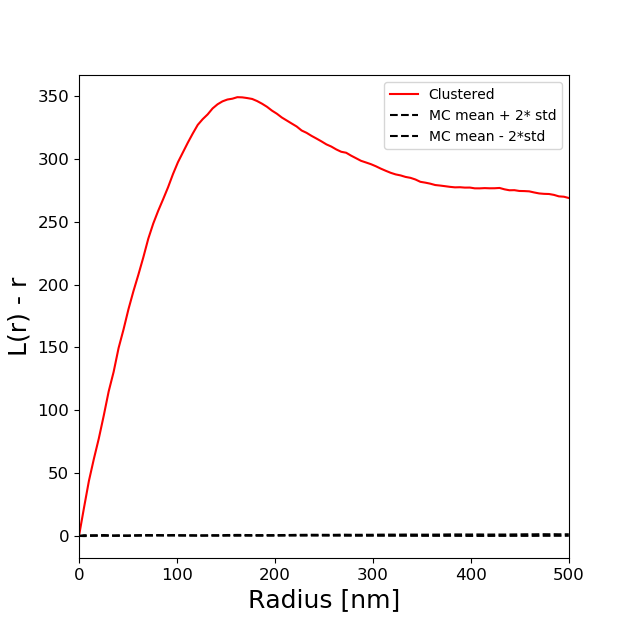

In [11]:
figure = plt.figure()
ax = figure.add_subplot(111)
# ax.plot(np.linspace(0, rmax, 100), H, 'g-', label='Data')
# ax.plot(np.linspace(0, rmax, 100), Kest.Hfunction(rand_xy, r, mode='ripley'), 'k-', label='Random')
ax.plot(np.linspace(0, rmax, 100), Kest.Hfunction(clust_xy, r, mode='ripley'), 'r-', label='Clustered')
ax.plot(np.linspace(0, rmax, 100), Hci[0], 'k--', label='MC mean + 2* std')
ax.plot(np.linspace(0, rmax, 100), Hci[1], 'k--', label='MC mean - 2*std')
# ax.plot(np.linspace(0, rmax, 100), Kest.Hfunction(disp_xy, r, mode='ripley'), 'b-', label='Dispersed')
ax.set_xlim([0, rmax])
ax.tick_params(labelsize='large')
ax.legend()
plt.xlabel('Radius [nm]', fontsize=18)
plt.ylabel('L(r) - r', fontsize=18)
plt.show()

<IPython.core.display.Javascript object>


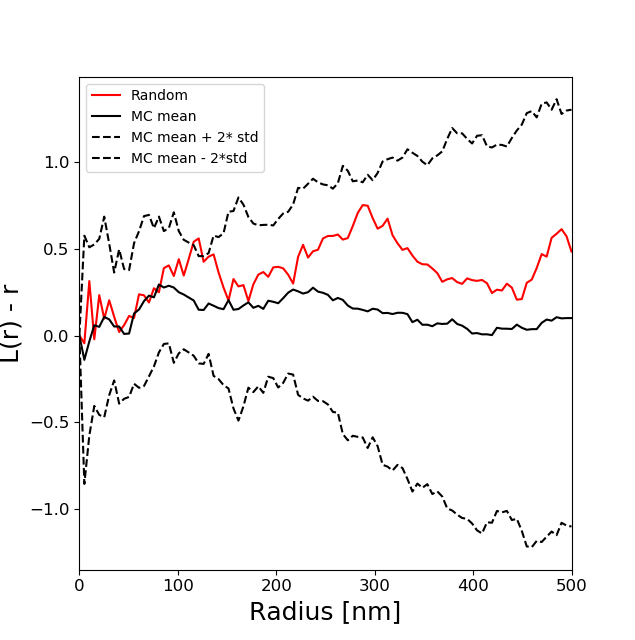

In [8]:
figure = plt.figure()
ax = figure.add_subplot(111)
# ax.plot(np.linspace(0, rmax, 100), H, 'g-', label='Data')
ax.plot(np.linspace(0, rmax, 100), Kest.Hfunction(rand_xy, r, mode='ripley'), 'r-', label='Random')
ax.plot(np.linspace(0, rmax, 100), Hci[0], 'k-', label='MC mean')
# ax.plot(np.linspace(0, rmax, 100), Kest.Hfunction(clust_xy, r, mode='ripley'), 'r-', label='Clustered')
ax.plot(np.linspace(0, rmax, 100), Hci[1], 'k--', label='MC mean + 2* std')
ax.plot(np.linspace(0, rmax, 100), Hci[2], 'k--', label='MC mean - 2*std')
# ax.plot(np.linspace(0, rmax, 100), Kest.Hfunction(disp_xy, r, mode='ripley'), 'b-', label='Dispersed')
ax.set_xlim([0, rmax])
ax.tick_params(labelsize='large')
ax.legend()
plt.xlabel('Radius [nm]', fontsize=18)
plt.ylabel('L(r) - r', fontsize=18)
plt.show()